In [1]:
### General imports
import pandas as pd
import xarray as xr
import re
import numpy as np
import urllib.request

### Plots
import matplotlib.pyplot as plt
import seaborn as sns

### Stats
from scipy.special import gamma
from scipy.integrate import quad

In [2]:
### Color list 
dark_oranges = sns.color_palette("Oranges", n_colors=15)[4:]
dark_purples = sns.color_palette("Purples", n_colors=9)[4:]
dark_greens = sns.color_palette("Greens", n_colors=9)[4:]

In [3]:
# URL of the data file
url = "https://crudata.uea.ac.uk/cru/data/temperature/HadCRUT5.0Analysis_gl.txt"

# Fetch the data from the URL
with urllib.request.urlopen(url) as response:
    lines = response.read().decode('utf-8').splitlines()

# Parse the lines to extract the data
data = []
months = []
years = []
for line in lines[::2]:
    values = line.split(' ')[2:-1]
    years.append(line.split(' ')[0])
    years.append(line.split(' ')[1])
    for i, value in enumerate(values):
        if value != '':
            data.append(value)
            months.append(i)

# Convert the list of lists into a NumPy array
data_array = np.array(data, dtype=float)
data_array = data_array

# Print the resulting NumPy array
print(data_array)

time = pd.date_range(start='1850-01-01', end='2025-12-01', freq='MS')
temperature_data = xr.DataArray(
    data_array[:], 
    coords={'time': time}, 
    dims='time', 
    name='temperature - HadCRU5'
)


[-0.734 -0.36  -0.627 ... -9.999 -9.999 -9.999]


In [4]:

# =========================
# ENSO (ONI) loading & annual mean
# =========================
oni_path = '/home/jmindlin/BF_codes/data/oni_data.txt'

def load_oni_xarray(src):
    # Adjust reading logic to your file; this mirrors your approach.
    df_oni = np.loadtxt(src, skiprows=1, max_rows=76)
    oni = np.concatenate([df_oni[i, 1:13].flatten() for i in range(df_oni.shape[0]-1)])
    t_monthly = pd.date_range('1950-01-01', '2025-01-01', freq='ME')
    da = xr.DataArray(
        oni, dims=["time"], coords={"time": t_monthly}, name="oni",
        attrs={"units": "degC", "source": "NOAA"}
    )
    return da

oni = load_oni_xarray(oni_path)
oni_son = oni.sel(time=oni['time.month'].isin([10, 11, 12]))
oni_son_annual = oni.groupby('time.year').mean(dim='time').sel(year=slice('1979','2024'))

In [5]:
### Compute IOD index for 1979-2024 (SON) The IOD is calculated as the difference between sea surface temperature (SST) anomalies in the western (10°S–10°N, 50°–70°E) and eastern (10°S –0°, 90°–110°E) tropical Indian Ocean.
sst = xr.open_dataset('/climca/data/OBS/ERSSTv5/sst.mnmean.nc')
# Select SON months
sst_son = sst['sst'].sel(time=sst['time.month'].isin([10, 11, 12]))
# Group by year and compute mean
sst_son_annual = sst_son.groupby('time.year').mean(dim='time')
# Select regions
west_box = sst_son_annual.sel(lat=slice(10, -10), lon=slice(50, 70))
east_box = sst_son_annual.sel(lat=slice(10, -10), lon=slice(90, 110))
# Compute area-weighted mean SST in each box
def area_weighted_mean(da):
    weights = np.cos(np.deg2rad(da['lat']))
    weights /= weights.mean()
    return (da * weights).mean(dim=['lat', 'lon'])
sst_west = area_weighted_mean(west_box)
sst_east = area_weighted_mean(east_box)
# Compute IOD index
iod_son_annual = sst_west - sst_east
iod_son_annual = iod_son_annual.sel(year=slice('1979','2024'))
iod_son_annual.name = "IOD_index"
### Compute correlation between tmean and IOD for Sep-Nov

In [6]:
### Precipitation
pr = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/precip_1979_2024_mon.nc")['precip']
pr_son = pr.sel(time=pr['time.month'].isin([10, 11, 12]))
## select AU box (AU; 12°–38°S, 117°–152°E)
pr_au_son = pr_son.sel(lat=slice(-12, -38), lon=slice(117, 152)).mean(dim={'lat','lon'})
pr_au_son_annual = pr_au_son.groupby('time.year').mean(dim='time')
## select SESA box (AU; 25°–35°S, 60°–50°W)
pr_sesa_son = pr_son.sel(lat=slice(-25, -35), lon=slice(300, 310)).mean(dim={'lat','lon'})
pr_sesa_son_annual = pr_au_son.groupby('time.year').mean(dim='time')

In [7]:
### Regression coefficient and Bayes factor  for ENSO -> PR_AU (one index) 

def bayes_factor_JZS(n, k, R2):
    """
    JZS Bayes factor for linear regression with k predictors (excluding intercept).
    Mirrors the 1D integral used in Wetzels & Wagenmakers (2012).
    """
    def integrand(g):
        return (1 + g)**((n - k - 1) / 2) * (1 + (1 - R2) * g)**(-(n - 1) / 2) * g**(-3 / 2) * np.exp(-n / (2 * g))
    integral, _ = quad(integrand, 0, np.inf, limit=200)
    # Prefactor; reduces to a simple function of n when k=1
    BF = ((n / 2)**(k / 2) * gamma((k + 1) / 2)) / (np.sqrt(np.pi) * gamma(k / 2)) * integral
    return BF


def bayes_factor_JZS_partial(n, k_1, k_0, R2_1, R2_0):
    """
    JZS Bayes factor for linear regression with k predictors (excluding intercept).
    Mirrors the 1D integral used in Wetzels & Wagenmakers (2012).
    """
    def integrand_1(g):
        return (1 + g)**((n - k_1 - 1) / 2) * (1 + (1 - R2_1) * g)**(-(n - 1) / 2) * g**(-3 / 2) * np.exp(-n / (2 * g))
    def integrand_0(g):
        return (1 + g)**((n - k_0 - 1) / 2) * (1 + (1 - R2_0) * g)**(-(n - 1) / 2) * g**(-3 / 2) * np.exp(-n / (2 * g))
    integral_1, _ = quad(integrand_1, 0, np.inf, limit=200)
    integral_0, _ = quad(integrand_0, 0, np.inf, limit=200)
    # Prefactor; reduces to a simple function of n when k=1
    BF = integral_1 / integral_0
    return BF

### standardize and linearly detrend
def standardize_detrend(da):
    da_detrended = da.polyfit(dim='year', deg=1).polyfit_coefficients.sel(degree=0) + \
        (da - (da.polyfit(dim='year', deg=1).polyfit_coefficients.sel(degree=1) * da['year']))
    da_std = (da_detrended - da_detrended.mean()) / da_detrended.std()
    return da_std


In [8]:
### AU precipitation vs ENSO and IOD
oni_son_annual_std = standardize_detrend(oni_son_annual)
iod_son_annual_std = standardize_detrend(iod_son_annual)
pr_au_son_annual_std = standardize_detrend(pr_au_son_annual)

from scipy.stats import pearsonr, t as student_t
r_enso_pr, p_enso_pr = pearsonr(oni_son_annual_std.values, pr_au_son_annual_std.values)
# R^2 from simple regression of residuals on ONI
n = len(oni_son_annual_std)
X_enso = np.column_stack([np.ones(n), oni_son_annual_std])
beta_enso, *_ = np.linalg.lstsq(X_enso, pr_au_son_annual_std, rcond=None) 
yhat_enso = X_enso @ beta_enso
resid_enso = pr_au_son_annual_std - yhat_enso
RSS_enso = np.sum(resid_enso**2)
TSS_enso = np.sum((pr_au_son_annual_std - np.mean(pr_au_son_annual_std))**2)
R2_enso = 1 - RSS_enso / TSS_enso

r_iod_pr, p_iod_pr = pearsonr(iod_son_annual_std.values, pr_au_son_annual_std.values)
### same code but iod
n = len(iod_son_annual_std)
X_iod = np.column_stack([np.ones(n), iod_son_annual_std])
beta_iod, *_ = np.linalg.lstsq(X_iod, pr_au_son_annual_std, rcond=None)
yhat_iod = X_iod @ beta_iod
resid_iod = pr_au_son_annual_std - yhat_iod
RSS_iod = np.sum(resid_iod**2)
TSS_iod = np.sum((pr_au_son_annual_std - np.mean(pr_au_son_annual_std))**2)
R2_iod = 1 - RSS_iod / TSS_iod

r_enso_iod, p_enso_iod = pearsonr(oni_son_annual_std.values, iod_son_annual_std.values)
### sam but for ENSO -> IOD
n = len(oni_son_annual_std)
X_enso_iod = np.column_stack([np.ones(n), oni_son_annual_std])
beta_enso_iod, *_ = np.linalg.lstsq(X_enso_iod, iod_son_annual_std, rcond=None)
yhat_enso_iod = X_enso_iod @ beta_enso_iod
resid_enso_iod = iod_son_annual_std - yhat_enso_iod
RSS_enso_iod = np.sum(resid_enso_iod**2)
TSS_enso_iod = np.sum((iod_son_annual_std - np.mean(iod_son_annual_std))**2)
R2_enso_iod = 1 - RSS_enso_iod / TSS_enso_iod

### mulivariate regression ENSO + IOD -> PR_AU
X_multi = np.column_stack([np.ones(n), oni_son_annual_std, iod_son_annual_std])
beta_multi, *_ = np.linalg.lstsq(X_multi, pr_au_son_annual_std, rcond=None)
yhat_multi = X_multi @ beta_multi
resid_multi = pr_au_son_annual_std - yhat_multi
RSS_multi = np.sum(resid_multi**2)
TSS_multi = np.sum((pr_au_son_annual_std - np.mean(pr_au_son_annual_std))**2)
R2_multi = 1 - RSS_multi / TSS_multi

R2_multi_iod = beta_multi[2]**2 * (1 - r_enso_pr**2) + R2_enso
R2_multi_enso = beta_multi[1]**2 * (1 - r_iod_pr**2) + R2_iod

In [9]:

BF10_enso_pr = bayes_factor_JZS(n=n, k=1, R2=R2_enso)
BF10_enso_pr_r = bayes_factor_JZS(n=n, k=1, R2=r_enso_pr**2)
BF10_iod_pr = bayes_factor_JZS(n=n, k=1, R2=R2_iod)
# BF10_eno_iod = bayes_factor_JZS(n=n, k=1, R2=R2_enso_iod)
BF10_multi = bayes_factor_JZS(n=n, k=2, R2=R2_multi)
BF10_multi_iod = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_iod, R2_0=R2_enso)
BF10_multi_enso = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_enso, R2_0=R2_iod)
print("ENSO -> PR_AU: r = %.2f, p = %.3f, BF10 = %.2f" % (r_enso_pr, p_enso_pr, BF10_enso_pr))
print("ENSO -> PR_AU: r = %.2f, p = %.3f, BF10 = %.2f" % (r_enso_pr, p_enso_pr, BF10_enso_pr_r))

print("IOD -> PR_AU: r = %.2f, p = %.3f, BF10 = %.2f" % (r_iod_pr, p_iod_pr, BF10_iod_pr))
# print("ENSO -> IOD: r = %.2f, p = %.3f, BF10 = %.2f" % (r_enso_iod, p_enso_iod, BF10_eno_iod))
print("ENSO + IOD -> PR_AU: r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi[1], beta_multi[2], BF10_multi))
print("ENSO (+IOD) -> PR_AU: r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi[1], beta_multi[2], BF10_multi_iod))
print("IOD (+ENSO) -> PR_AU: r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi[1], beta_multi[2], BF10_multi_enso))

ENSO -> PR_AU: r = -0.54, p = 0.000, BF10 = 111.78
ENSO -> PR_AU: r = -0.54, p = 0.000, BF10 = 111.78
IOD -> PR_AU: r = -0.46, p = 0.001, BF10 = 12.09
ENSO + IOD -> PR_AU: r_enso = -0.41, r_iod = -0.27, BF10 = 799.03
ENSO (+IOD) -> PR_AU: r_enso = -0.41, r_iod = -0.27, BF10 = 0.78
IOD (+ENSO) -> PR_AU: r_enso = -0.41, r_iod = -0.27, BF10 = 8.67


/tmp/ipykernel_1958146/4248432443.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=BF_values, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])
/tmp/ipykernel_1958146/4248432443.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, max(BF_values)*2)


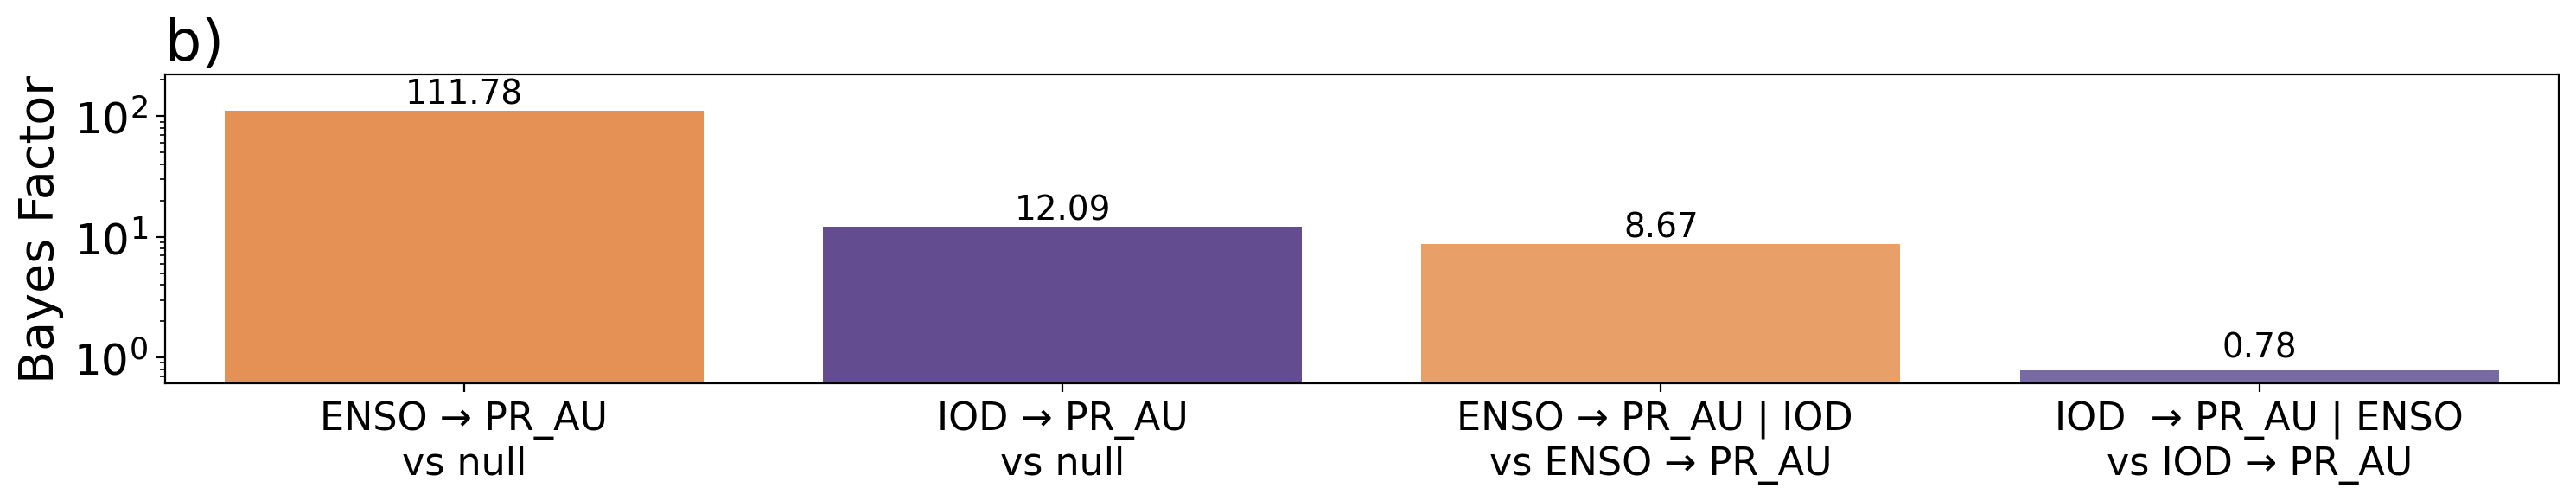

Bayes Factor Comparisons:


In [10]:
### Bayes factor comparison Hypotheses (H_enso, H_iod, H_both, H_null) using color list from above
BF_enso_vs_null = BF10_enso_pr
BF_iod_vs_null = BF10_iod_pr


### Plot barplots for comparison
labels = [
    "ENSO → PR_AU\nvs null",
    "IOD → PR_AU\nvs null",
    "ENSO → PR_AU | IOD \nvs ENSO → PR_AU",
    "IOD  → PR_AU | ENSO\nvs IOD → PR_AU",
]
BF_values = [BF_enso_vs_null, BF_iod_vs_null,  BF10_multi_enso, BF10_multi_iod]
plt.figure(figsize=(15, 3),dpi=200)

sns.barplot(x=labels, y=BF_values, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])
plt.yscale('log')
plt.ylim(0, max(BF_values)*2)
plt.ylabel('Bayes Factor',fontsize=20)
plt.title('b)',loc='left',fontsize=24)
for i, v in enumerate(BF_values):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom',fontsize=14)

## make ticks large
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()
### Print Bayes factor comparisons
print("Bayes Factor Comparisons:")

ENSO -> PR_SESA: r = 0.67, p = 0.000, BF10 = 31143.66
IOD -> PR_SESA: r = 0.44, p = 0.002, BF10 = 7.23
ENSO|IOD -> PR_SESA: r_enso = 0.60, r_iod = 0.17, BF10 = 1799.59
IOD|ENSO -> PR_SESA: r_enso = 0.60, r_iod = 0.17, BF10 = 0.25


/tmp/ipykernel_1958146/2709958650.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_sesa, y=BF_values_sesa, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])


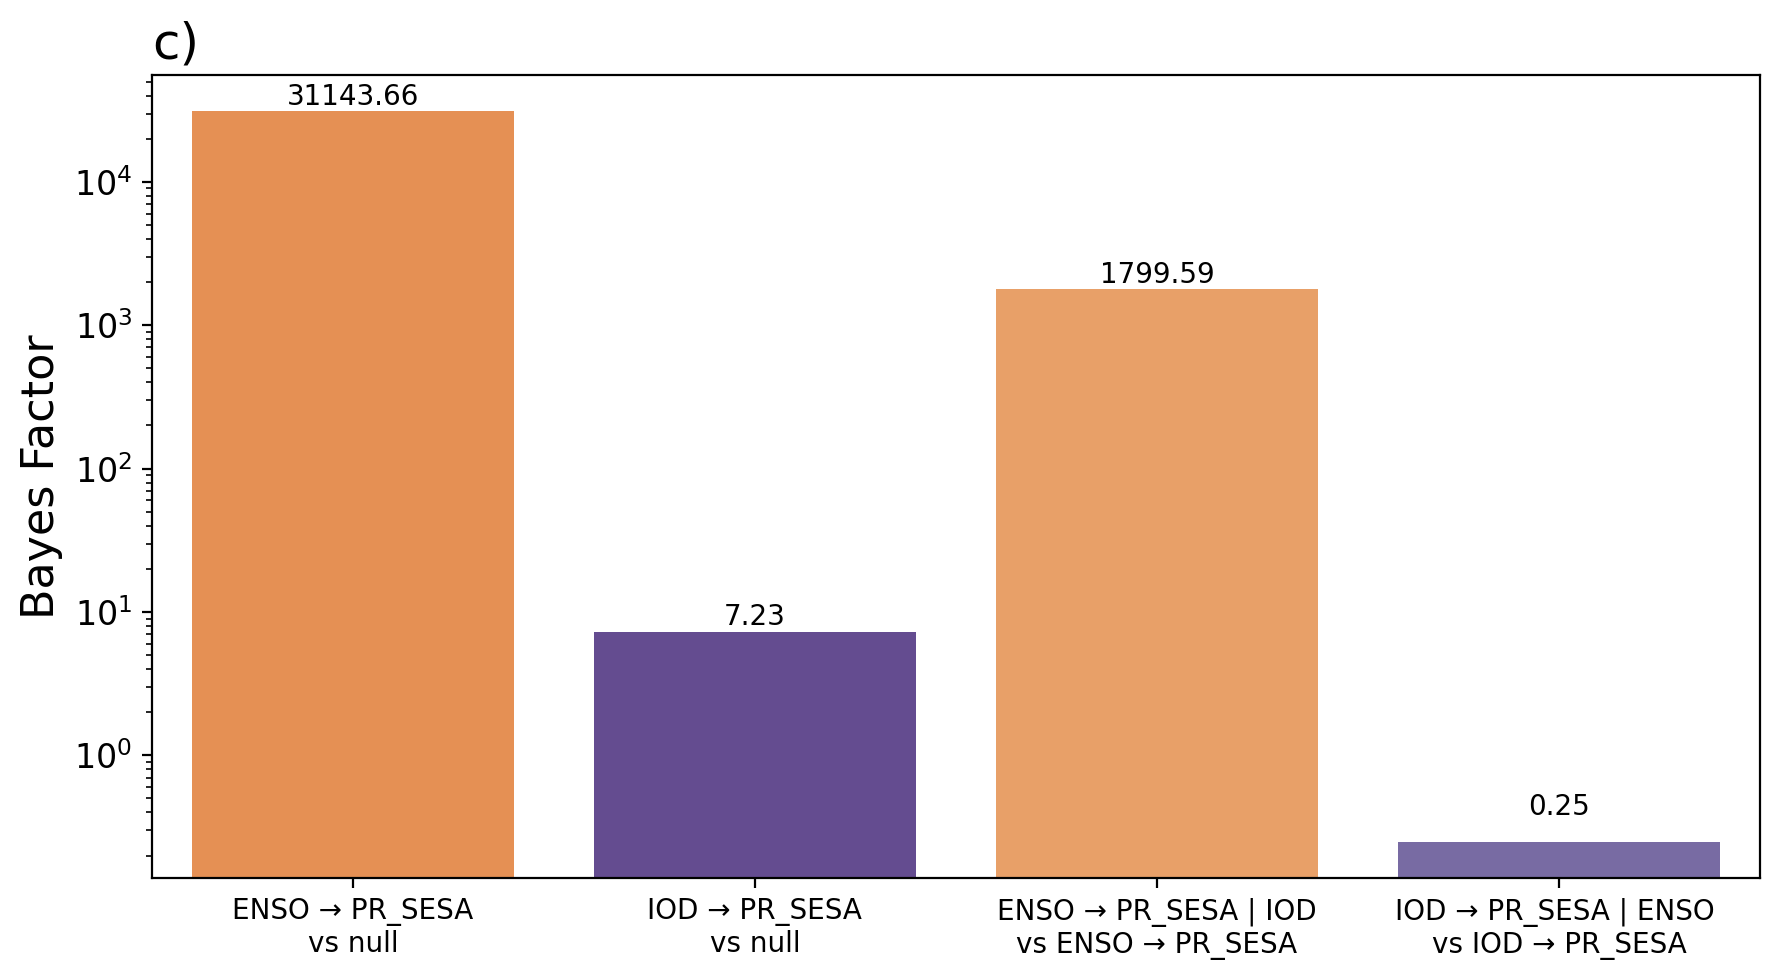

In [11]:
### SESA precipitation vs ENSO and IOD
pr_sesa_son_annual_std = standardize_detrend(pr_sesa_son_annual)
r_enso_pr_sesa, p_enso_pr_sesa = pearsonr(oni_son_annual_std.values, pr_sesa_son_annual_std.values)
# R^2 from simple regression of residuals on ONI
n = len(oni_son_annual_std)
X_enso_sesa = np.column_stack([np.ones(n), oni_son_annual_std])
beta_enso_sesa, *_ = np.linalg.lstsq(X_enso_sesa, pr_sesa_son_annual_std, rcond=None)
yhat_enso_sesa = X_enso_sesa @ beta_enso_sesa
resid_enso_sesa = pr_sesa_son_annual_std - yhat_enso_sesa
RSS_enso_sesa = np.sum(resid_enso_sesa**2)
TSS_enso_sesa = np.sum((pr_sesa_son_annual_std - np.mean(pr_sesa_son_annual_std))**2)
R2_enso_sesa = 1 - RSS_enso_sesa / TSS_enso_sesa
r_iod_pr_sesa, p_iod_pr_sesa = pearsonr(iod_son_annual_std.values, pr_sesa_son_annual_std.values)
### same code but iod
n = len(iod_son_annual_std)
X_iod_sesa = np.column_stack([np.ones(n), iod_son_annual_std])
beta_iod_sesa, *_ = np.linalg.lstsq(X_iod_sesa, pr_sesa_son_annual_std, rcond=None)
yhat_iod_sesa = X_iod_sesa @ beta_iod_sesa
resid_iod_sesa = pr_sesa_son_annual_std - yhat_iod_sesa
RSS_iod_sesa = np.sum(resid_iod_sesa**2)
TSS_iod_sesa = np.sum((pr_sesa_son_annual_std - np.mean(pr_sesa_son_annual_std))**2)
R2_iod_sesa = 1 - RSS_iod_sesa / TSS_iod_sesa
r_enso_iod, p_enso_iod = pearsonr(oni_son_annual_std.values, iod_son_annual_std.values)
### mulivariate regression ENSO + IOD -> PR_SESA
X_multi_sesa = np.column_stack([np.ones(n), oni_son_annual_std, iod_son_annual_std])
beta_multi_sesa, *_ = np.linalg.lstsq(X_multi_sesa, pr_sesa_son_annual_std, rcond=None)
yhat_multi_sesa = X_multi_sesa @ beta_multi_sesa
resid_multi_sesa = pr_sesa_son_annual_std - yhat_multi_sesa
RSS_multi_sesa = np.sum(resid_multi_sesa**2)
TSS_multi_sesa = np.sum((pr_sesa_son_annual_std - np.mean(pr_sesa_son_annual_std))**2)
R2_multi_sesa = 1 - RSS_multi_sesa / TSS_multi_sesa
R2_multi_iod_sesa = beta_multi_sesa[2]**2 * (1 - r_enso_pr_sesa**2) + R2_enso_sesa
R2_multi_enso_sesa = beta_multi_sesa[1]**2 * (1 - r_iod_pr_sesa**2) + R2_iod_sesa
BF10_enso_pr_sesa = bayes_factor_JZS(n=n, k=1, R2=R2_enso_sesa)
BF10_iod_pr_sesa = bayes_factor_JZS(n=n, k=1, R2=R2_iod_sesa)
BF10_multi_iod_sesa = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_iod_sesa, R2_0=R2_enso_sesa)
BF10_multi_enso_sesa = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_enso_sesa, R2_0=R2_iod_sesa)
print("ENSO -> PR_SESA: r = %.2f, p = %.3f, BF10 = %.2f" % (r_enso_pr_sesa, p_enso_pr_sesa, BF10_enso_pr_sesa))
print("IOD -> PR_SESA: r = %.2f, p = %.3f, BF10 = %.2f" % (r_iod_pr_sesa, p_iod_pr_sesa, BF10_iod_pr_sesa))
print("ENSO|IOD -> PR_SESA: r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi_sesa[1], beta_multi_sesa[2], BF10_multi_enso_sesa))
print("IOD|ENSO -> PR_SESA: r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi_sesa[1], beta_multi_sesa[2], BF10_multi_iod_sesa))

### Figure
labels_sesa = [
    "ENSO → PR_SESA\nvs null",
    "IOD → PR_SESA\nvs null",
    "ENSO → PR_SESA | IOD\nvs ENSO → PR_SESA",
    "IOD → PR_SESA | ENSO \nvs IOD → PR_SESA",
]
BF_values_sesa = [BF10_enso_pr_sesa, BF10_iod_pr_sesa,  BF10_multi_enso_sesa, BF10_multi_iod_sesa]
plt.figure(figsize=(9, 5),dpi=200)
sns.barplot(x=labels_sesa, y=BF_values_sesa, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])
plt.yscale('log')
plt.ylabel('Bayes Factor',fontsize=16)
plt.title('c)',loc='left',fontsize=18)
for i, v in enumerate(BF_values_sesa):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom')
## make ticks large
plt.xticks(fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [12]:
# === Load Tmin and Tmax ===
tmin = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/tmax_1979_2024_mon.nc")['tmax']
tmax = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/tmin_1979_2024_mon.nc")['tmin']

# === Compute Tmean ===
tmean = (tmin + tmax) / 2
tmean.name = "tmean"
tmean.attrs['units'] = tmin.attrs.get('units', 'degC')
tmean.attrs['long_name'] = "Monthly Mean Temperature"

### Repeat analysis with temperature in SESZ
tmean_son = tmean.sel(time=tmean['time.month'].isin([10, 11, 12]))
tmean_son_annual = tmean_son.groupby('time.year').mean(dim='time')
tmean_son_annual_sesa = tmean_son_annual.sel(lat=slice(-25, -35), lon=slice(300, 310)).mean(dim={'lat','lon'})
tmean_son_annual_sesa_std = standardize_detrend(tmean_son_annual_sesa)
r_enso_tmean_sesa, p_enso_tmean_sesa = pearsonr(oni_son_annual_std.values, tmean_son_annual_sesa_std.values)
# R^2 from simple regression of residuals on ONI
n = len(oni_son_annual_std)
X_enso_tmean_sesa = np.column_stack([np.ones(n), oni_son_annual_std])
beta_enso_tmean_sesa, *_ = np.linalg.lstsq(X_enso_tmean_sesa, tmean_son_annual_sesa_std, rcond=None)
yhat_enso_tmean_sesa = X_enso_tmean_sesa @ beta_enso_tmean_sesa
resid_enso_tmean_sesa = tmean_son_annual_sesa_std - yhat_enso_tmean_sesa
RSS_enso_tmean_sesa = np.sum(resid_enso_tmean_sesa**2)
TSS_enso_tmean_sesa = np.sum((tmean_son_annual_sesa_std - np.mean(tmean_son_annual_sesa_std))**2)
R2_enso_tmean_sesa = 1 - RSS_enso_tmean_sesa / TSS_enso_tmean_sesa
r_iod_tmean_sesa, p_iod_tmean_sesa = pearsonr(iod_son_annual_std.values, tmean_son_annual_sesa_std.values)
### same code but iod
n = len(iod_son_annual_std)
X_iod_tmean_sesa = np.column_stack([np.ones(n), iod_son_annual_std])
beta_iod_tmean_sesa, *_ = np.linalg.lstsq(X_iod_tmean_sesa, tmean_son_annual_sesa_std, rcond=None)
yhat_iod_tmean_sesa = X_iod_tmean_sesa @ beta_iod_tmean_sesa
resid_iod_tmean_sesa = tmean_son_annual_sesa_std - yhat_iod_tmean_sesa
RSS_iod_tmean_sesa = np.sum(resid_iod_tmean_sesa**2)
TSS_iod_tmean_sesa = np.sum((tmean_son_annual_sesa_std - np.mean(tmean_son_annual_sesa_std))**2)
R2_iod_tmean_sesa = 1 - RSS_iod_tmean_sesa / TSS_iod_tmean_sesa
r_enso_iod, p_enso_iod = pearsonr(oni_son_annual_std.values, iod_son_annual_std.values)
### mulivariate regression ENSO + IOD -> Tmean_SESA
X_multi_tmean_sesa = np.column_stack([np.ones(n), oni_son_annual_std, iod_son_annual_std])
beta_multi_tmean_sesa, *_ = np.linalg.lstsq(X_multi_tmean_sesa, tmean_son_annual_sesa_std, rcond=None)
yhat_multi_tmean_sesa = X_multi_tmean_sesa @ beta_multi_tmean_sesa
resid_multi_tmean_sesa = tmean_son_annual_sesa_std - yhat_multi_tmean_sesa
RSS_multi_tmean_sesa = np.sum(resid_multi_tmean_sesa**2)
TSS_multi_tmean_sesa = np.sum((tmean_son_annual_sesa_std - np.mean(tmean_son_annual_sesa_std))**2)
R2_multi_tmean_sesa = 1 - RSS_multi_tmean_sesa / TSS_multi_tmean_sesa
R2_multi_iod_tmean_sesa = beta_multi_tmean_sesa[2]**2 * (1 - r_enso_tmean_sesa**2) + R2_enso_tmean_sesa
R2_multi_enso_tmean_sesa = beta_multi_tmean_sesa[1]**2 * (1 - r_iod_tmean_sesa**2) + R2_iod_tmean_sesa
BF10_enso_tmean_sesa = bayes_factor_JZS(n=n, k=1, R2=R2_enso_tmean_sesa)
BF10_iod_tmean_sesa = bayes_factor_JZS(n=n, k=1, R2=R2_iod_tmean_sesa)
BF10_multi_iod_tmean_sesa = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_iod_tmean_sesa, R2_0=R2_enso_tmean_sesa)
BF10_multi_enso_tmean_sesa = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_enso_tmean_sesa, R2_0=R2_iod_tmean_sesa)
print("ENSO -> Tmean_SESA: r = %.2f, p = %.3f, BF10 = %.2f" % (r_enso_tmean_sesa, p_enso_tmean_sesa, BF10_enso_tmean_sesa))
print("IOD -> Tmean_SESA: r = %.2f, p = %.3f, BF10 = %.2f" % (r_iod_tmean_sesa, p_iod_tmean_sesa, BF10_iod_tmean_sesa))
print("ENSO-> Tmean_SESA |IOD : r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi_tmean_sesa[1], beta_multi_tmean_sesa[2], BF10_multi_enso_tmean_sesa))
print("IOD -> Tmean_SESA |ENSO: r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi_tmean_sesa[1], beta_multi_tmean_sesa[2], BF10_multi_iod_tmean_sesa))



ENSO -> Tmean_SESA: r = -0.04, p = 0.790, BF10 = 0.07
IOD -> Tmean_SESA: r = 0.29, p = 0.049, BF10 = 0.45
ENSO-> Tmean_SESA |IOD : r_enso = -0.22, r_iod = 0.40, BF10 = 0.50
IOD -> Tmean_SESA |ENSO: r_enso = -0.22, r_iod = 0.40, BF10 = 6.49


/tmp/ipykernel_1958146/1897901457.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_tmean, y=BF_values_tmean, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])
/tmp/ipykernel_1958146/1897901457.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, max(BF_values_tmean)*2)


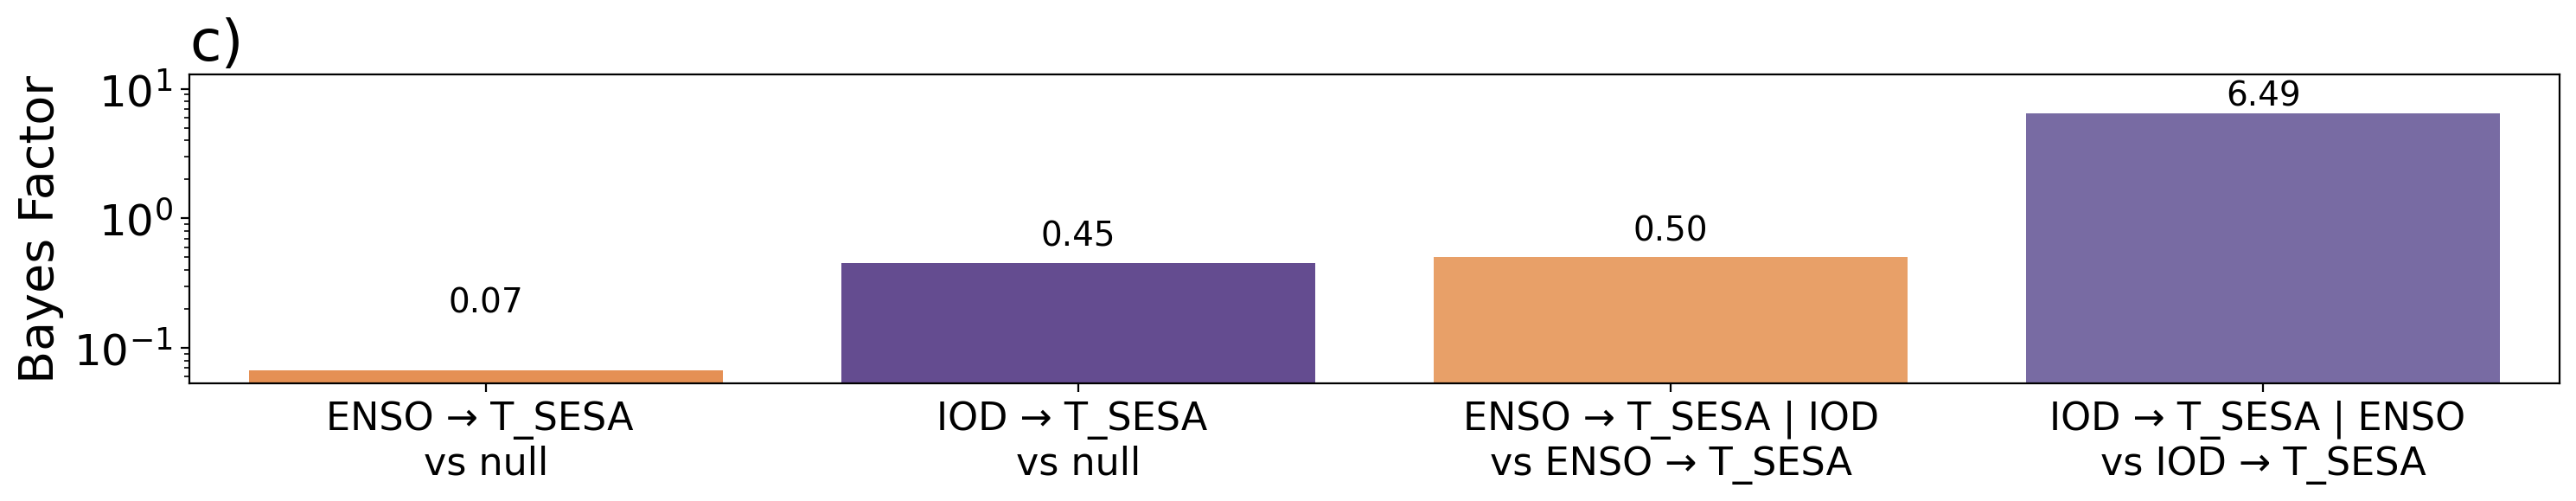

Bayes Factor Comparisons:


In [20]:
### Figure
labels_tmean = [
    "ENSO → T_SESA \nvs null",
    "IOD → T_SESA \nvs null",
    "ENSO → T_SESA | IOD\nvs ENSO → T_SESA",
    "IOD → T_SESA | ENSO \nvs IOD → T_SESA",
]
BF_values_tmean = [BF10_enso_tmean_sesa, BF10_iod_tmean_sesa,  BF10_multi_enso_tmean_sesa, BF10_multi_iod_tmean_sesa]
plt.figure(figsize=(15, 3),dpi=200)
sns.barplot(x=labels_tmean, y=BF_values_tmean, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])
plt.yscale('log')
plt.ylim(0, max(BF_values_tmean)*2)
### include ytick in 0.1
plt.yticks([0.1, 1, 10], [r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$'])
plt.ylabel('Bayes Factor',fontsize=20)
plt.title('c)',loc='left',fontsize=24)
for i, v in enumerate(BF_values_tmean):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom',fontsize=14)

## make ticks large
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()
### Print Bayes factor comparisons
print("Bayes Factor Comparisons:")


In [14]:
# === Load Tmin and Tmax ===
tmin = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/tmax_1979_2024_mon.nc")['tmax']
tmax = xr.open_dataset("/climca/data/OBS/CPC/cpc_data/tmin_1979_2024_mon.nc")['tmin']

# === Compute Tmean ===
tmean = (tmin + tmax) / 2
tmean.name = "tmean"
tmean.attrs['units'] = tmin.attrs.get('units', 'degC')
tmean.attrs['long_name'] = "Monthly Mean Temperature"

### Repeat analysis with temperature in SESZ
tmean_son = tmean.sel(time=tmean['time.month'].isin([10, 11, 12]))
tmean_son_annual = tmean_son.groupby('time.year').mean(dim='time')
### repeat temperature case for AUS


tmean_son_annual_au = tmean_son_annual.sel(lat=slice(-12, -38), lon=slice(117, 152)).mean(dim={'lat','lon'})
tmean_son_annual_au_std = standardize_detrend(tmean_son_annual_au)
r_enso_tmean_au, p_enso_tmean_au = pearsonr(oni_son_annual_std.values, tmean_son_annual_au_std.values)
# R^2 from simple regression of residuals on ONI
n = len(oni_son_annual_std)
X_enso_tmean_au = np.column_stack([np.ones(n), oni_son_annual_std])
beta_enso_tmean_au, *_ = np.linalg.lstsq(X_enso_tmean_au, tmean_son_annual_au_std, rcond=None)
yhat_enso_tmean_au = X_enso_tmean_au @ beta_enso_tmean_au
resid_enso_tmean_au = tmean_son_annual_au_std - yhat_enso_tmean_au
RSS_enso_tmean_au = np.sum(resid_enso_tmean_au**2)
TSS_enso_tmean_au = np.sum((tmean_son_annual_au_std - np.mean(tmean_son_annual_au_std))**2)
R2_enso_tmean_au = 1 - RSS_enso_tmean_au / TSS_enso_tmean_au
r_iod_tmean_au, p_iod_tmean_au = pearsonr(iod_son_annual_std.values, tmean_son_annual_au_std.values)
### same code but iod
n = len(iod_son_annual_std)
X_iod_tmean_au = np.column_stack([np.ones(n), iod_son_annual_std])
beta_iod_tmean_au, *_ = np.linalg.lstsq(X_iod_tmean_au, tmean_son_annual_au_std, rcond=None)
yhat_iod_tmean_au = X_iod_tmean_au @ beta_iod_tmean_au
resid_iod_tmean_au = tmean_son_annual_au_std - yhat_iod_tmean_au
RSS_iod_tmean_au = np.sum(resid_iod_tmean_au**2)
TSS_iod_tmean_au = np.sum((tmean_son_annual_au_std - np.mean(tmean_son_annual_au_std))**2)
R2_iod_tmean_au = 1 - RSS_iod_tmean_au / TSS_iod_tmean_au
r_enso_iod, p_enso_iod = pearsonr(oni_son_annual_std.values, iod_son_annual_std.values)
### mulivariate regression ENSO + IOD -> Tmean_SESA
X_multi_tmean_au = np.column_stack([np.ones(n), oni_son_annual_std, iod_son_annual_std])
beta_multi_tmean_au, *_ = np.linalg.lstsq(X_multi_tmean_au, tmean_son_annual_au_std, rcond=None)
yhat_multi_tmean_au = X_multi_tmean_au @ beta_multi_tmean_au
resid_multi_tmean_au = tmean_son_annual_au_std - yhat_multi_tmean_au
RSS_multi_tmean_au = np.sum(resid_multi_tmean_au**2)
TSS_multi_tmean_au = np.sum((tmean_son_annual_au_std - np.mean(tmean_son_annual_au_std))**2)
R2_multi_tmean_au = 1 - RSS_multi_tmean_au / TSS_multi_tmean_au
R2_multi_iod_tmean_au = beta_multi_tmean_au[2]**2 * (1 - r_enso_tmean_au**2) + R2_enso_tmean_au
R2_multi_enso_tmean_au = beta_multi_tmean_au[1]**2 * (1 - r_iod_tmean_au**2) + R2_iod_tmean_au
BF10_enso_tmean_au = bayes_factor_JZS(n=n, k=1, R2=R2_enso_tmean_au)
BF10_iod_tmean_au = bayes_factor_JZS(n=n, k=1, R2=R2_iod_tmean_au)
BF10_multi_iod_tmean_au = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_iod_tmean_au, R2_0=R2_enso_tmean_au)
BF10_multi_enso_tmean_au = bayes_factor_JZS_partial(n=n, k_1=2, k_0=1, R2_1=R2_multi_enso_tmean_au, R2_0=R2_iod_tmean_au)
print("ENSO -> Tmean_SESA: r = %.2f, p = %.3f, BF10 = %.2f" % (r_enso_tmean_au, p_enso_tmean_au, BF10_enso_tmean_au))
print("IOD -> Tmean_SESA: r = %.2f, p = %.3f, BF10 = %.2f" % (r_iod_tmean_au, p_iod_tmean_au, BF10_iod_tmean_au))
print("ENSO-> Tmean_SESA |IOD : r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi_tmean_au[1], beta_multi_tmean_au[2], BF10_multi_enso_tmean_au))
print("IOD -> Tmean_SESA |ENSO: r_enso = %.2f, r_iod = %.2f, BF10 = %.2f" % (beta_multi_tmean_au[1], beta_multi_tmean_au[2], BF10_multi_iod_tmean_au))



ENSO -> Tmean_SESA: r = 0.44, p = 0.002, BF10 = 6.77
IOD -> Tmean_SESA: r = 0.39, p = 0.008, BF10 = 2.14
ENSO-> Tmean_SESA |IOD : r_enso = 0.33, r_iod = 0.23, BF10 = 1.98
IOD -> Tmean_SESA |ENSO: r_enso = 0.33, r_iod = 0.23, BF10 = 0.53


/tmp/ipykernel_1958146/2833131056.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels_tmean_au, y=BF_values_tmean_au, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])
/tmp/ipykernel_1958146/2833131056.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, max(BF_values_tmean_au)*2)


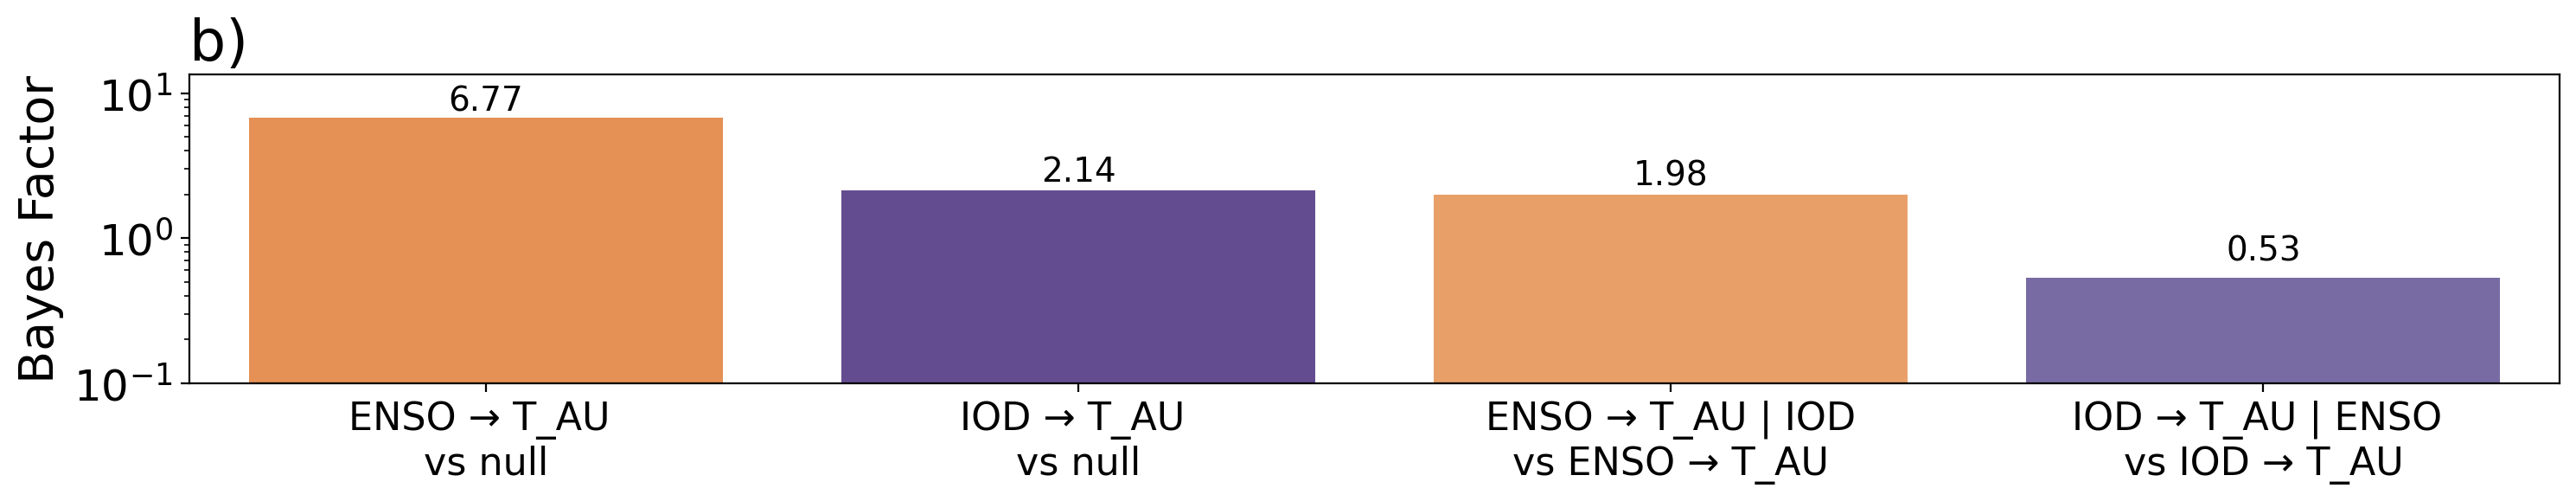

In [21]:
### Same figure as above but for temperature in AUS
labels_tmean_au = [
    "ENSO → T_AU \nvs null",
    "IOD → T_AU \nvs null",
    "ENSO → T_AU | IOD\nvs ENSO → T_AU",
    "IOD → T_AU | ENSO \nvs IOD → T_AU",
]
BF_values_tmean_au = [BF10_enso_tmean_au, BF10_iod_tmean_au,  BF10_multi_enso_tmean_au, BF10_multi_iod_tmean_au]
plt.figure(figsize=(15, 3),dpi=200)
sns.barplot(x=labels_tmean_au, y=BF_values_tmean_au, palette=[dark_oranges[3], dark_purples[3], dark_oranges[2], dark_purples[2]])
plt.yscale('log')
plt.ylim(0, max(BF_values_tmean_au)*2)
plt.yticks([0.1, 1, 10], [r'10$^{-1}$', r'10$^{0}$', r'10$^{1}$'])
plt.ylabel('Bayes Factor',fontsize=20)
plt.title('b)',loc='left',fontsize=24)
for i, v in enumerate(BF_values_tmean_au):
    plt.text(i, v + 0.1, f"{v:.2f}", ha='center', va='bottom',fontsize=14)
## make ticks large
plt.xticks(fontsize=16)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()
